# Reconstructing the booking history of the *UHCW* dataset
The [University Hospitals - Coventry & Warwickshire](https://www.uhcw.nhs.uk) (UHCW) has set up an online [portal](https://www.swiftqueue.co.uk/uhcw.php) to facilitate the booking of blood tests appointments in 18 centers around Coventry (UK).  


Available appointments have been recorded in the dataset `appointments.csv`.  A preliminary investigation of the dataset is done in `UHCW_EDA.ipynb`.

In this notebook we reconstruct the booking history of all appointments in all centers.

## Imports

In [1]:
import os
import pandas as pd
import datetime
import pytz
import matplotlib.pyplot as plt
%matplotlib inline

## Constants

In [2]:
tz_utc = pytz.timezone("UTC")  # timestamp is in UTC standard
tz_london = pytz.timezone("Europe/London")  # test centers are in Coventry, UK

## Helper functions

In [3]:
def cartesianProduct(left, right):
    """Returns Cartesian product of dataframe.
    From https://stackoverflow.com/a/53699013/9472676 with some arrangement:
    """
    # Rename columns if "key" already exists.
    if "key" in list(left.columns):
        key_x = "key_x"
    else:
        key_x = ""
    if "key" in list(right.columns):
        key_y = "key_x"
    else:
        key_y = ""
    new_key = hash("".join(list(left.columns) + list(right.columns)))
    left.rename(index=str, columns={"key": str(new_key)}, inplace=True)
    right.rename(index=str, columns={"key": str(new_key)}, inplace=True)
    # Calculate Cartesian product
    df_cartesian = left.assign(key=1).merge(
        right.assign(key=1), on='key'
    ).drop('key', 1)
    # Rename columns back to "key" if they had been changed
    left.rename(index=str, columns={str(new_key): "key"}, inplace=True)
    right.rename(index=str, columns={str(new_key): "key"}, inplace=True)
    if (key_x != "") and (key_y != ""):
        df_cartesian.rename(index=str, columns={str(new_key)+"_x": "key_x"}, inplace=True)
        df_cartesian.rename(index=str, columns={str(new_key)+"_y": "key_y"}, inplace=True)
    else:
        df_cartesian.rename(index=str, columns={str(new_key): "key"}, inplace=True)
    return df_cartesian


In [4]:
def spot_action(df, col='key'):
    """
    Detects booking and cancellation of dataframe.
    
    Parameter
    ---------
    df: dataframe with 0's and 1's
    
    Returns
    -------
    df, modified in place, replacing a transition from 0 to 1 with "cancel",
    a transition from 1 to 0 with "book",
    and "none" otherwise.
    """
    df[col] = df[col] - df[col].shift(1)
    df[col].fillna(method='bfill', inplace=True)
    df[col] = df[col].astype(int)
    df[col] = df[col].apply(lambda delta: "cancel" if delta == 1 else ("book" if delta == -1 else "none"))
    return df

## Data
Read in the `csv` file.

In [5]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
filename = 'sample_appointments.csv'  # appointments.csv
foldername = 'Data/UHCW'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)

filesize = os.path.getsize(filepath)
if filesize > 1e6:
    print("Size of data file: {}MB.".format(filesize//1000000))
elif filesize > 1e3:
    print("Size of data file: {}KB.".format(filesize//1000))
else:
    print("Size of data file: {}B.".format(filesize))
print("Loading data...")
raw_data = pd.read_csv(filepath, sep=';')
print("Number of records: {0}.".format(raw_data.shape[0]))
print("Column names:\n{}".format("\n".join(raw_data.columns)))

Thursday 07 February 2019, 23:51:09
Size of data file: 291MB.
Loading data...
Number of records: 5117059.
Column names:
appointment timestamp
center age group
center id
test type
grab timestamp
CPU times: user 2.74 s, sys: 220 ms, total: 2.96 s
Wall time: 2.96 s


Work with a copy `df` of the `raw_data` dataframe.

In [6]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))

df = raw_data.copy()
df = df[['appointment timestamp', 'center id', 'center age group', 'test type', 'grab timestamp']]
df.columns = ['appointment', 'id', 'age group', 'test type', 'grab']
df['appointment'] = pd.to_datetime(df['appointment'])
df['appointment'] = df['appointment'].apply(lambda ts: ts.tz_localize(tz_london))
df['grab'] = pd.to_datetime(df['grab'])
df['grab'] = df['grab'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_london))

df = df[['id', 'test type', 'age group', 'grab', 'appointment']]

Thursday 07 February 2019, 23:51:12
CPU times: user 4min 21s, sys: 4.95 s, total: 4min 26s
Wall time: 4min 23s


## Drop column `age group` 
In `UHCW_EDA.ipynb` we have noted that each center serves exactly one age group, so we will ignore the column `age group`:

In [7]:
df.drop('age group', axis=1, inplace=True)

## Working on a restricted dataset
Also in `UHCW_EDA.ipynb`, we have noted that test center `10254` delivers only one test type and has the smallest number of records across all centers.
Therefore, for the sake of simplicity, we will begin with a restricted set containing only the data for center `10254`.
In a second phase, we will consider center `10352` which delivers two test types and has the smallest number of records given its number of test types.

In [8]:
selected_centers = [10254, 10352] # [10352] # [10254] # 

In [9]:
df0 = df.loc[df['id'].apply(lambda x: x == selected_centers[0]), df.columns]

## Sorting for convenience of reading

In [10]:
df0.sort_values(['id', 'test type', 'appointment', 'grab'], inplace=True)

## Selecting an appointment

We will sometimes inspect one particular appointment.  Indeed, closer inspection of the dataset (not shown in `UHCW_EDA.ipynb`) reveals that the following appointment has been cancelled - and booked again.

In [11]:
selected_appointment = pd.Timestamp(datetime.datetime(2019, 1, 17, 11, 30)).tz_localize(tz_london)

In [12]:
df0[df0['appointment'] == selected_appointment].head()

,id,test type,grab,appointment
213759,10254,Blood Test,2019-01-15 14:10:00+00:00,2019-01-17 11:30:00+00:00
267453,10254,Blood Test,2019-01-15 14:20:00+00:00,2019-01-17 11:30:00+00:00
321128,10254,Blood Test,2019-01-15 14:30:00+00:00,2019-01-17 11:30:00+00:00
374779,10254,Blood Test,2019-01-15 14:40:00+00:00,2019-01-17 11:30:00+00:00
428669,10254,Blood Test,2019-01-15 14:50:00+00:00,2019-01-17 11:30:00+00:00


## Generating the "schedule"
It turns out that the `selected_appointment` was initially not available, butr then later became available.  That is, it had been already booked at the beginning of the dataset and was subsequently cancelled.  To detect this, we generate the `schedule`, that is, the full list of (`grab`, `appointment`) pairs (where `grab` does not occur after `appointment`) from the original dataset `df`.  

We first generate the full list of `grab` timestamps:

In [13]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
grabs = pd.DataFrame()
grabs['grab'] = df['grab'].drop_duplicates().reset_index(drop=True).sort_values(ascending=True)

Thursday 07 February 2019, 23:55:38
CPU times: user 34.6 ms, sys: 8.98 ms, total: 43.6 ms
Wall time: 42 ms


then the full list of `appointment` timestamps:

In [14]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
appointments = pd.DataFrame()
appointments['appointment'] = df['appointment'].drop_duplicates().reset_index(drop=True).sort_values(ascending=True)

Thursday 07 February 2019, 23:55:38
CPU times: user 55.5 ms, sys: 5.66 ms, total: 61.2 ms
Wall time: 59.5 ms


then their Cartesian product and keep only the relevant side of the diagonal:

In [15]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
schedule = cartesianProduct(grabs, appointments)
schedule.query('grab <= appointment', inplace=True)

Thursday 07 February 2019, 23:55:38
CPU times: user 615 ms, sys: 63.3 ms, total: 679 ms
Wall time: 675 ms


By inspection we may now see the `grab` timestamps which are missing in `df` for the `selected_appointment`:

In [16]:
schedule[schedule['appointment'] == selected_appointment].head()

,grab,appointment
181,2019-01-15 13:40:00+00:00,2019-01-17 11:30:00+00:00
9977,2019-01-15 13:50:00+00:00,2019-01-17 11:30:00+00:00
19773,2019-01-15 14:00:00+00:00,2019-01-17 11:30:00+00:00
29569,2019-01-15 14:10:00+00:00,2019-01-17 11:30:00+00:00
39365,2019-01-15 14:20:00+00:00,2019-01-17 11:30:00+00:00


Now we compare `df0` against `schedule` to spot the missing rows:

In [17]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
df0_compare = pd.merge(
    schedule,
    df0[['grab', 'appointment']].assign(key=1),
    on=['appointment', 'grab'],
    how='outer'
)
df0_compare.fillna(0, inplace=True)
df0_compare['key'] = df0_compare['key'].astype(int)

Thursday 07 February 2019, 23:55:38
CPU times: user 135 ms, sys: 39.4 ms, total: 174 ms
Wall time: 173 ms


A `0` indicates that the (`grab`, `appointment`) pair is missing in `df0`, and a `1` that it was there.  For instance, we can inspect the records corresponding to the `selected_appointment`:

In [18]:
df0_compare[df0_compare['appointment'] == selected_appointment].head()

,grab,appointment,key
181,2019-01-15 13:40:00+00:00,2019-01-17 11:30:00+00:00,0
9977,2019-01-15 13:50:00+00:00,2019-01-17 11:30:00+00:00,0
19773,2019-01-15 14:00:00+00:00,2019-01-17 11:30:00+00:00,0
29569,2019-01-15 14:10:00+00:00,2019-01-17 11:30:00+00:00,1
39365,2019-01-15 14:20:00+00:00,2019-01-17 11:30:00+00:00,1


A transition from `0` to `1` represents a cancellation, and a transition from `1` to `0` represents a booking:

In [19]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))

df0_action = df0_compare.groupby(['appointment']).apply(spot_action)

Thursday 07 February 2019, 23:55:39
CPU times: user 15.1 s, sys: 251 ms, total: 15.3 s
Wall time: 15.2 s


To get the history we filter out the rows with `none`:

In [20]:
df0_history = df0_action.loc[df0_action['key'] != "none", :]

Finally we extract the booking history for the `selected_appointment`:

In [21]:
df0_history[df0_history['appointment'] == selected_appointment]

,grab,appointment,key
29569,2019-01-15 14:10:00+00:00,2019-01-17 11:30:00+00:00,cancel
782092,2019-01-16 10:50:00+00:00,2019-01-17 11:30:00+00:00,book


We can visualize the booking history for all the appointments at the selected center, where bookings are in blue and cancellations in red:

In [22]:
df0_bookings = df0_history.loc[df0_history['key'] == 'book', ['appointment', 'grab']]
df0_cancellations = df0_history.loc[df0_history['key'] == 'cancel', ['appointment', 'grab']]

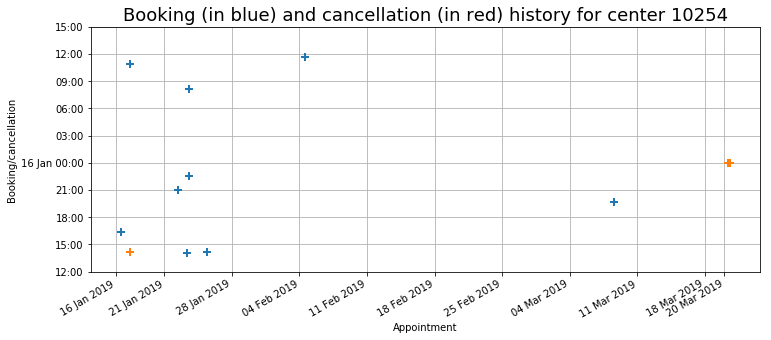

In [23]:
# Plot
ax = df0_bookings.plot(
    x='appointment', y='grab',
    #style='.b', 
    **{"marker": "+", "markersize": 8, "markeredgewidth": 2, "linestyle": ""},
    figsize=(12, 5)
);
df0_cancellations.plot(    
    x='appointment', y='grab',
    #style='.r', 
    **{"marker": "+", "markersize": 8, "markeredgewidth": 2, "linestyle": ""},
    ax=ax
);

# x-labeling
ax.set_xlabel("Appointment");
appt_min = df.loc[df['id'] == 10254, 'appointment'].min()
appt_max = df.loc[df['id'] == 10254, 'appointment'].max()
appt_date_range = pd.date_range(
    pd.Timestamp(appt_min.year, appt_min.month, appt_min.day),
    pd.Timestamp(appt_max.year, appt_max.month, appt_max.day),
    freq="W-MON"
)
appt_date_range = appt_date_range.append(
    pd.DatetimeIndex([x.date() for x in [appt_min, appt_max]])
)
ax.set_xticks(appt_date_range);
ax.set_xticklabels([pd.to_datetime(x).strftime("%d %b %Y")
                   for x in appt_date_range])

# y-labeling
ax.set_ylabel("Booking/cancellation");
grab_min = df['grab'].min()
grab_max = df['grab'].max()
grab_date_range = pd.date_range(
    pd.Timestamp(grab_min.year, grab_min.month, grab_min.day, grab_min.hour-1), 
    pd.Timestamp(grab_max.year, grab_max.month, grab_max.day, grab_min.hour+3), 
    freq="3H");
ax.set_yticks(grab_date_range);
ax.set_yticklabels([pd.to_datetime(x).strftime("%d %b %H:00")
                    if x.hour == 0
                    else pd.to_datetime(x).strftime("%H:00")
                   for x in grab_date_range])

# Further plot layout
ax.get_legend().remove()
ax.set_title("Booking (in blue) and cancellation (in red) history for center {}".format(selected_centers[0]), fontsize=18);
ax.grid()
#plt.savefig("center-10254-history-with-artefacts.png")

---
## Reconstruct *entire* booking history (of *all* appointments in *all* centers)

We will now revisit what we did above for one test center in a way that will make it possible to apply to the entire dataset.  

For speed, we restrict `df` to a smaller subset, namely to two centers:

In [24]:
df = df.loc[df['id'].apply(lambda x: x in selected_centers), df.columns]

We duplicate `schedule`, one for each (`id`, `test type`) pair: 

In [25]:
%%time 
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
schedule_duplicate = pd.concat(
    [schedule.assign(id=id_item).assign(type=type_item)
     for id_item in list(df['id'].unique())
     for type_item in list(df['test type'].unique())
     ]
    )
schedule_duplicate.rename(index=str, columns={'type': 'test type'}, inplace=True)
schedule_duplicate = schedule_duplicate[['id', 'test type', 'grab', 'appointment']]
schedule_duplicate.sort_values(['id', 'test type', 'grab', 'appointment'],
    inplace=True
)
schedule_duplicate.info()

Thursday 07 February 2019, 23:55:55
<class 'pandas.core.frame.DataFrame'>
Index: 3712300 entries, 0 to 930619
Data columns (total 4 columns):
id             int64
test type      object
grab           datetime64[ns, Europe/London]
appointment    datetime64[ns, Europe/London]
dtypes: datetime64[ns, Europe/London](2), int64(1), object(1)
memory usage: 141.6+ MB
CPU times: user 1.61 s, sys: 350 ms, total: 1.96 s
Wall time: 1.96 s


We now compare the recorded data in `df` against the schedule:

In [26]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
df_compare = pd.merge(
    schedule_duplicate,
    df.assign(key=1),
    on=['id', 'test type', 'appointment', 'grab'],
    how='outer'
)
df_compare.fillna(0, inplace=True)
df_compare['key'] = df_compare['key'].astype(int)

Thursday 07 February 2019, 23:55:57
CPU times: user 735 ms, sys: 210 ms, total: 945 ms
Wall time: 942 ms


For example, we may verify that we obtain the same results as earlier, whenwe worked with the single test center 10254:

In [27]:
df_compare[
    (df_compare['appointment'] == selected_appointment)
    & (df_compare['id'] == selected_centers[0])
].head()

,id,test type,grab,appointment,key
181,10254,Blood Test,2019-01-15 13:40:00+00:00,2019-01-17 11:30:00+00:00,0
9977,10254,Blood Test,2019-01-15 13:50:00+00:00,2019-01-17 11:30:00+00:00,0
19773,10254,Blood Test,2019-01-15 14:00:00+00:00,2019-01-17 11:30:00+00:00,0
29569,10254,Blood Test,2019-01-15 14:10:00+00:00,2019-01-17 11:30:00+00:00,1
39365,10254,Blood Test,2019-01-15 14:20:00+00:00,2019-01-17 11:30:00+00:00,1


Calculate the booking history:

In [28]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))

df_action = df_compare.groupby(['id', 'test type', 'appointment']).apply(spot_action)

df_history = df_action.loc[df_action['key'] != "none", :]

df_history.info()

Thursday 07 February 2019, 23:55:58
<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 20250 to 3702675
Data columns (total 5 columns):
id             114 non-null int64
test type      114 non-null object
grab           114 non-null datetime64[ns, Europe/London]
appointment    114 non-null datetime64[ns, Europe/London]
key            114 non-null object
dtypes: datetime64[ns, Europe/London](2), int64(1), object(2)
memory usage: 5.3+ KB
CPU times: user 1min 13s, sys: 1.48 s, total: 1min 14s
Wall time: 1min 14s


In [29]:
df_bookings = df_history.loc[df_history['key'] == 'book', ['id', 'test type', 'appointment', 'grab']]
df_cancellations = df_history.loc[df_history['key'] == 'cancel', ['id', 'test type', 'appointment', 'grab']]

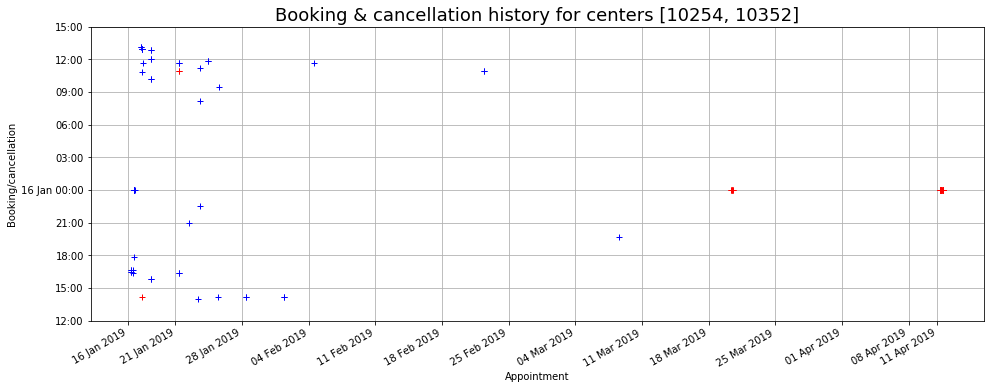

In [30]:
fig, ax = plt.subplots(figsize=(16, 6));
df_bookings.plot(x='appointment', y='grab', style='+b', ax=ax);
df_cancellations.plot(x='appointment', y='grab', style='+r', ax=ax);

# x-labeling
ax.set_xlabel("Appointment");
appt_min = df['appointment'].min()
appt_max = df['appointment'].max()
appt_date_range = pd.date_range(
    pd.Timestamp(appt_min.year, appt_min.month, appt_min.day),
    pd.Timestamp(appt_max.year, appt_max.month, appt_max.day),
    freq="W-MON"
)
appt_date_range = appt_date_range.append(
    pd.DatetimeIndex([x.date() for x in [appt_min, appt_max]])
)
ax.set_xticks(appt_date_range);
ax.set_xticklabels([pd.to_datetime(x).strftime("%d %b %Y")
                   for x in appt_date_range])

# y-labeling
ax.set_ylabel("Booking/cancellation");
grab_min = df['grab'].min()
grab_max = df['grab'].max()
grab_date_range = pd.date_range(
    pd.Timestamp(grab_min.year, grab_min.month, grab_min.day, grab_min.hour-1), 
    pd.Timestamp(grab_max.year, grab_max.month, grab_max.day, grab_min.hour+3), 
    freq="3H");
ax.set_yticks(grab_date_range);
ax.set_yticklabels([pd.to_datetime(x).strftime("%d %b %H:00")
                    if x.hour == 0
                    else pd.to_datetime(x).strftime("%H:00")
                   for x in grab_date_range])


ax.set_xlabel("Appointment");
ax.set_ylabel("Booking/cancellation");
ax.get_legend().remove()
ax.set_title("Booking & cancellation history for centers {}".format(selected_centers), fontsize=18);
ax.grid()

Let's zoom in on the first two weeks of appointments:

In [31]:
dt = pd.Timedelta("15D")
last_appointment = (appointments.min() + dt)[0].tz_localize(tz_london)

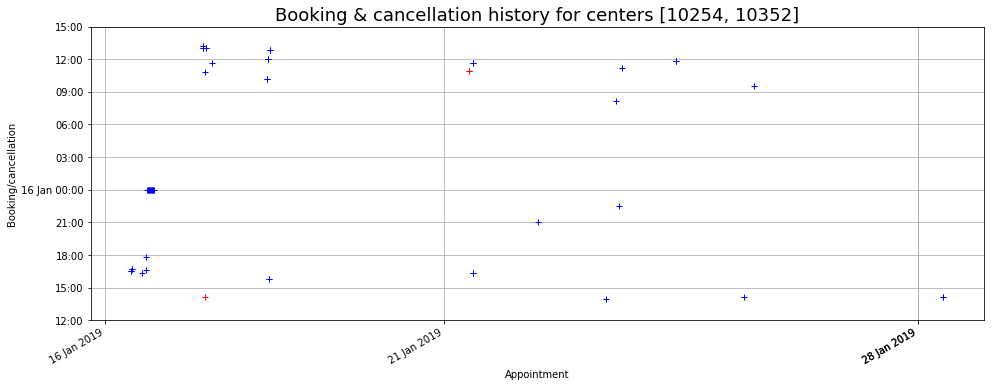

In [32]:
fig, ax = plt.subplots(figsize=(16, 6));
df_bookings.query('appointment < @last_appointment').plot(x='appointment', y='grab', style='+b', ax=ax);
df_cancellations.query('appointment < @last_appointment').plot(x='appointment', y='grab', style='+r', ax=ax);


# x-labeling
ax.set_xlabel("Appointment");
appt_min = df_bookings.query('appointment < @last_appointment')['appointment'].min()
appt_max = df_bookings.query('appointment < @last_appointment')['appointment'].max()
appt_date_range = pd.date_range(
    pd.Timestamp(appt_min.year, appt_min.month, appt_min.day),
    pd.Timestamp(appt_max.year, appt_max.month, appt_max.day),
    freq="W-MON"
)
appt_date_range = appt_date_range.append(
    pd.DatetimeIndex([x.date() for x in [appt_min, appt_max]])
)
ax.set_xticks(appt_date_range);
ax.set_xticklabels([pd.to_datetime(x).strftime("%d %b %Y")
                   for x in appt_date_range])

# y-labeling
ax.set_ylabel("Booking/cancellation");
grab_min = df['grab'].min()
grab_max = df['grab'].max()
grab_date_range = pd.date_range(
    pd.Timestamp(grab_min.year, grab_min.month, grab_min.day, grab_min.hour-1), 
    pd.Timestamp(grab_max.year, grab_max.month, grab_max.day, grab_min.hour+3), 
    freq="3H");
ax.set_yticks(grab_date_range);
ax.set_yticklabels([pd.to_datetime(x).strftime("%d %b %H:00")
                    if x.hour == 0
                    else pd.to_datetime(x).strftime("%H:00")
                   for x in grab_date_range])

# Further plot layout
ax.get_legend().remove()
ax.set_title("Booking & cancellation history for centers {}".format(selected_centers), fontsize=18);
ax.grid()